## MTNOY STOCK PRICE ANALYSIS

In [2]:
import requests
import pandas as pd
from config import settings
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
#loading the dataset

df = pd.read_csv("mtnoy_dataset.csv").set_index("date")
df.index = pd.to_datetime(df.index)
df= df.sort_index(ascending=True)

# creating the returns columns

df["returns"] = df["close"].pct_change() * 100
df_mtnoy_return = df["returns"].dropna()

### Model

In [18]:
# data split

cutoff_test = int(len(df_mtnoy_return) * 0.8)
y_mtnoy = df_mtnoy_return.iloc[:cutoff_test]

y_mtnoy.shape

(3314,)

In [19]:
# Build model with kag of 1

model = arch_model(
    y_mtnoy,
    p=1,
    q=1,
    rescale=False

).fit(disp=0)

model.summary

<bound method ARCHModelResult.summary of                      Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7944.67
Distribution:                  Normal   AIC:                           15897.3
Method:            Maximum Likelihood   BIC:                           15921.8
                                        No. Observations:                 3314
Date:                Sat, Dec 30 2023   Df Residuals:                     3313
Time:                        13:50:36   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.032

Our model is pretty good for prediction. the values are significant at 5% ;

According to the summary results of your model, the p-values for are less than 0.05, indicating that they are statistically significant at the 5% level. The p-value for δ1​ is very close to zero, indicating that it is also highly significant. The log-likelihood is -7944.67, the AIC is 15897.3, and the BIC is 15921.8.

### Model Evaluation

In [20]:
model.conditional_volatility.tail()

date
2020-09-03    3.546686
2020-09-04    3.481565
2020-09-08    3.373372
2020-09-09    3.249777
2020-09-10    3.241640
Name: cond_vol, dtype: float64

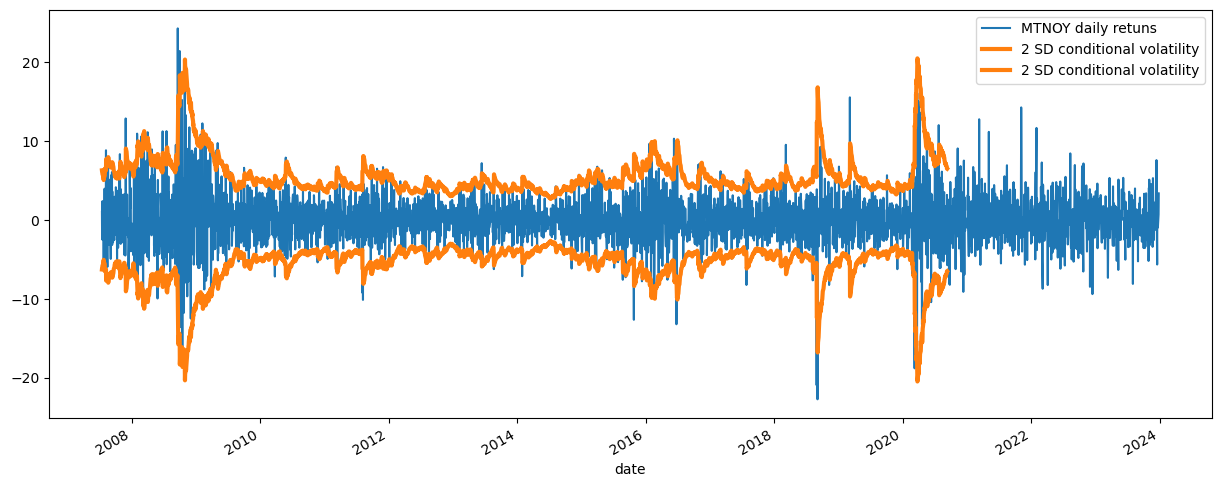

In [22]:
# PLot of MTNOY daily price volatility

fig, ax = plt.subplots(figsize=(15,6))

df_mtnoy_return.plot(ax=ax, label="MTNOY daily retuns" )

# 
(2 * model.conditional_volatility).plot(ax=ax,label="2 SD conditional volatility", linewidth=3)

(-2 *model.conditional_volatility.rename("")).plot(ax=ax,label="2 SD conditional volatility", linewidth=3, color="C1")

plt.legend();

The chart shows the MTNOY daily returns and the 2 SD conditional volatility over time. It seems that your model captures the volatility of the returns well, as the orange line follows the peaks and troughs of the blue line. However, this is not enough to evaluate the quality of your model. we should also check the standardized residuals.

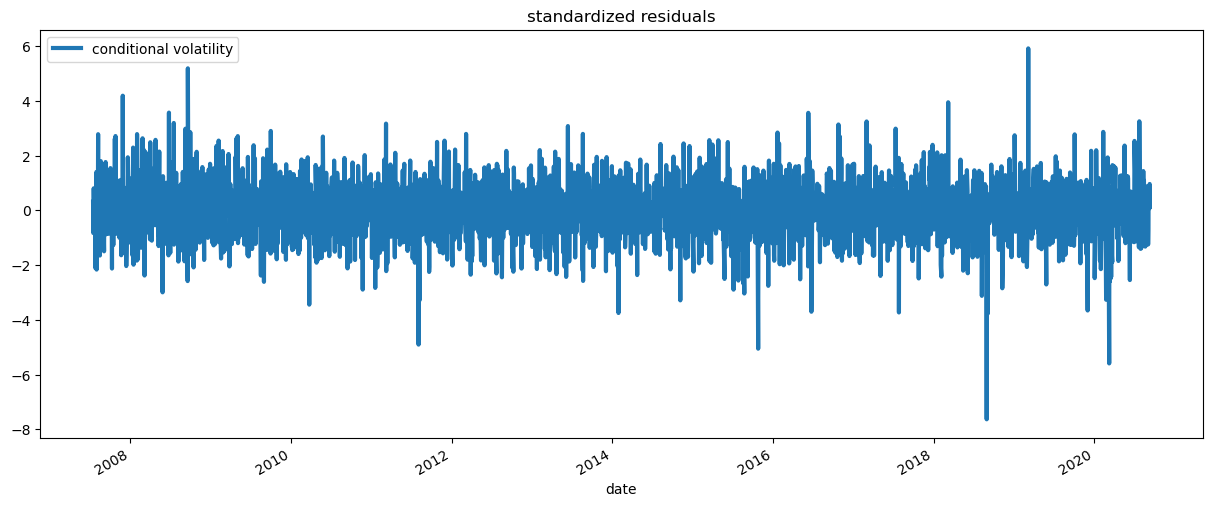

In [24]:
# PLot of MTNOY daily price volatility
fig, ax = plt.subplots(figsize=(15,6))

# 
(model.std_resid).plot(ax=ax,label="standardized residuals", linewidth=3)

plt.title("standardized residuals")
plt.legend();

The residuals seem to be randomly distributed around the zero line for most of the period, which is generally a positive indication of model fit. However, there are some noticeable spikes in the residuals, especially around 2009 and 2019, which might suggest periods of higher volatility that the model hasn’t accounted for.

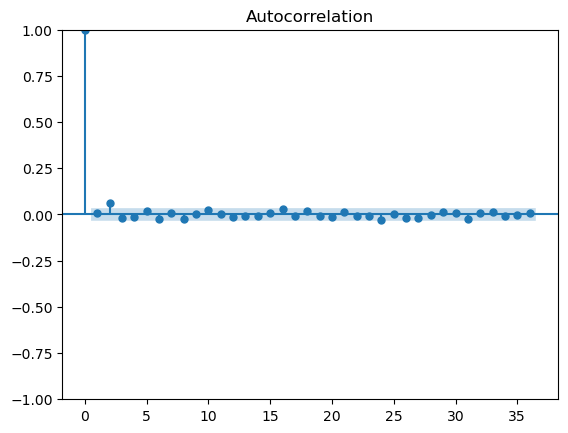

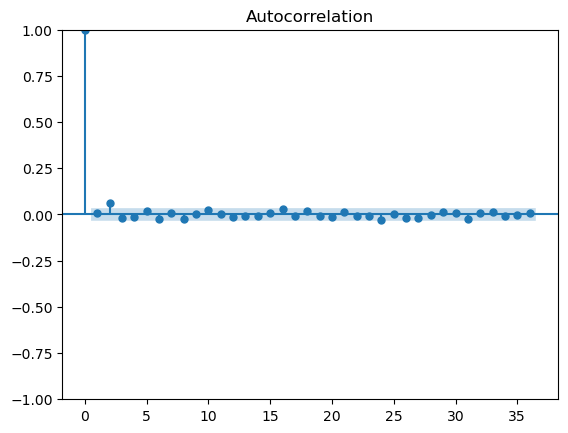

In [26]:
plot_acf(model.std_resid**2)

 ### Walk-Forward validation on our model

In [28]:
# Create empty list to hold predictions
predictions = []

# Calculate size of test data (20%)
test_size = int(len(df_mtnoy_return) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = df_mtnoy_return.iloc[: -(test_size - i)]

    # Train model
    model = arch_model(y_train, p=1, q=1, rescale=False).fit(disp=0)

    # Generate next prediction (volatility, not variance)
    next_pred = model.forecast(horizon=1, reindex=False).variance.iloc[0,0] ** 0.5

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=df_mtnoy_return.tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (828,)


date
2020-09-14    3.389251
2020-09-15    3.263430
2020-09-16    3.176302
2020-09-17    3.134454
2020-09-18    3.023431
dtype: float64

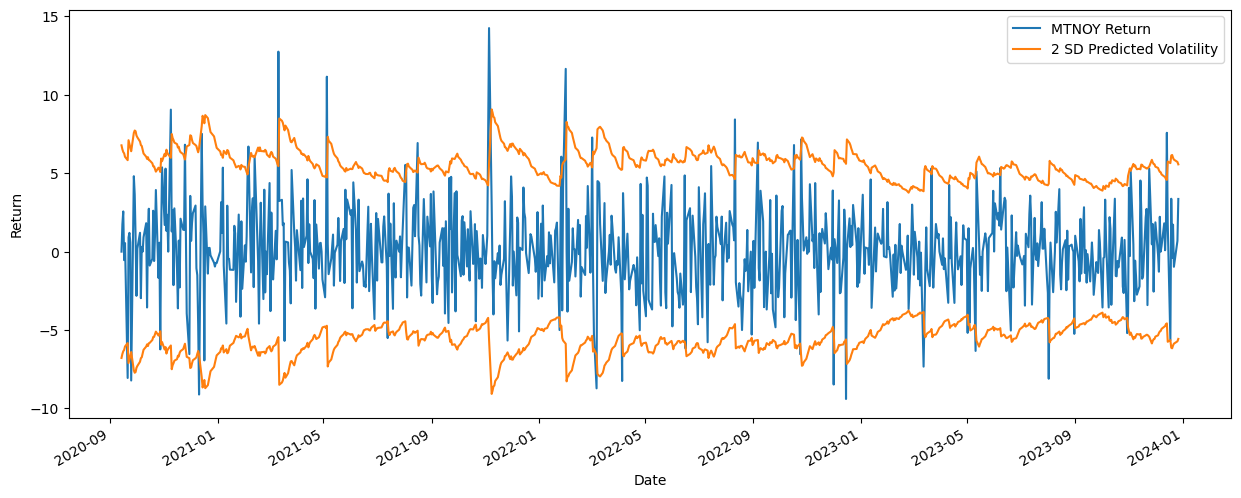

In [29]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
df_mtnoy_return.tail(test_size).plot(ax=ax, label="MTNOY Return")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv).plot(ax=ax, c="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

This looks pretty good. Our volatility predictions seem to follow the changes in returns over time. This is especially clear in the low-volatility period in the summer of 2022 and the high-volatility period in fall 2022.